#Spotify recommandation system using personality traits.
This project tries to implement a Quantum Neural Network for processing personality input in order to build a better recommandation system.

This is the architecture wished to be implemented in this project:

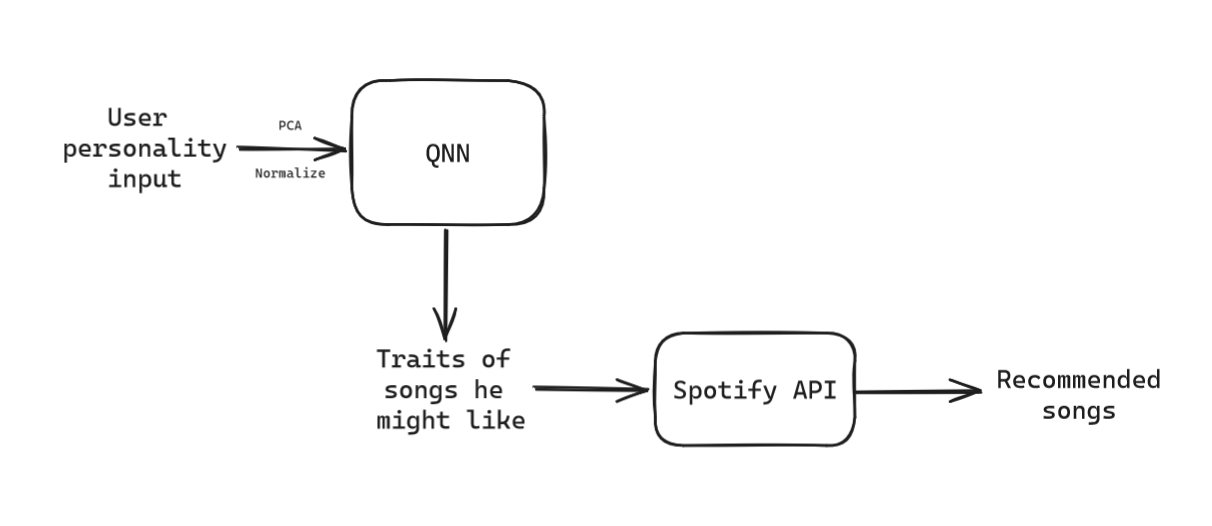

The dataset used in this project, as well as the data interpretation can be found in the following research paper: https://asmp-eurasipjournals.springeropen.com/articles/10.1186/s13636-022-00269-0

Firstly, we install the necesarry libraries. We need qiskit so we can implement the quantum circuits and qiskit-aer so we can run it on the simulator.
The other libraries would be used for data science and machine learning

In [ ]:
pip install qiskit qiskit-aer

In [ ]:
pip install pandas numpy matplotlib scikit-learn scipy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#This is necessary so we can read the dataset from the Google drive in a Google colab

#Firstly, import pandas in order to read the files
import pandas as pd

#Load the Big Five personality dataset. Make sure you have a folder in your drive called "Datasets for QML" and then another folder called "Personality" to assure functionality
personality_data = pd.read_csv('/content/drive/MyDrive/Datasets for QML/Personality/PER_dataset.csv')

#Print the file to check if the information is correctly interpreted
print(personality_data)

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from qiskit import QuantumCircuit, transpile, assemble
from qiskit_aer import Aer
import numpy as np
from scipy.optimize import minimize

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Datasets for QML/Personality/PER_dataset.csv')

# Select key personality traits and song characteristics
selected_personality_traits = ['Extraversion', 'Agreeableness', 'Conscientiousness', 'Neuroticism', 'Openness']
selected_song_traits = ['attacktime_mean', 'attacktime_std', 'attacktime_slope', 'attacktime_periodentropy',
                        'attackslope_mean', 'attackslope_std', 'attackslope_slope', 'attackslope_periodentropy',
                        'rms', 'lowenergy', 'eventdensity', 'pulseclarity', 'zerocross', 'brightness', 'centroid',
                        'spread', 'skewness', 'kurtosis', 'flatness', 'mirentropy', 'inharmonicity', 'activity',
                        'valence', 'tension', 'happy', 'sad', 'tender', 'anger', 'fear']

# Combine selected features
X = data[selected_personality_traits]
y = data[selected_song_traits]

# Normalize the feature columns
scaler_X = StandardScaler()
X_normalized = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_normalized = scaler_y.fit_transform(y)

# Apply PCA to reduce the dimensionality of X and y
pca_X = PCA(n_components=5)  # Reduce X to 5 components
pca_y = PCA(n_components=24)  # Reduce y to 24 components

X_reduced = pca_X.fit_transform(X_normalized)
y_reduced = pca_y.fit_transform(y_normalized)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_reduced, test_size=0.2, random_state=42)

# Quantum Neural Network (QNN) Parameters
num_qubits = 29  # Number of qubits (5 for input, 24 for output)
num_layers = 2  # Depth of the quantum circuit

# Ansatz and Measurement
def create_qnn(params):
    qc = QuantumCircuit(num_qubits, num_qubits)  # Add classical bits for measurement

    # Encode data
    for i in range(5):
        qc.ry(params[i], i)

    # Apply variational ansatz
    for _ in range(num_layers):
        for i in range(num_qubits):
            qc.ry(params[5 + i], i)
            qc.rz(params[5 + num_qubits + i], i)
        for i in range(num_qubits - 1):
            qc.cx(i, i + 1)
        qc.cx(num_qubits - 1, 0)  # Add entanglement

    # Measurement
    qc.measure(range(num_qubits), range(num_qubits))

    return qc

# Initialize parameters
num_params = 5 + 2 * num_qubits  # 5 for encoding, 2 * num_qubits for each layer's parameters
initial_params = np.random.rand(num_params)

# Function to predict song features based on user input
def predict_song_features(personality_input, params):
    # Normalize and reduce the input personality traits
    personality_input_normalized = scaler_X.transform(pd.DataFrame([personality_input], columns=selected_personality_traits))
    personality_input_reduced = pca_X.transform(personality_input_normalized)

    qc = create_qnn(np.concatenate((personality_input_reduced[0], params[5:])))

    # Simulate qc
    simulator = Aer.get_backend('qasm_simulator')
    compiled_circuit = transpile(qc, simulator)
    job = simulator.run(compiled_circuit, shots=512)  # Reduced number of shots
    result = job.result()
    counts = result.get_counts(qc)

    # Decode the measured counts to continuous values
    measured_values = [int(key, 2) * value for key, value in counts.items()]
    predicted_values = np.mean(measured_values) / 512  # Normalize the measurement

    # Create a vector with the predicted values for all song features
    predicted_song_features_reduced = np.full((1, pca_y.n_components_), predicted_values)

    # Inverse transform the PCA and scaler to get the original song features
    predicted_song_features = scaler_y.inverse_transform(pca_y.inverse_transform(predicted_song_features_reduced))

    return predicted_song_features[0]

# Define the loss function
def loss_function(params):
    predictions = []
    for personality_input in X_train:
        predicted_features = predict_song_features(personality_input, params)
        predictions.append(predicted_features)
    predictions = np.array(predictions)
    true_values = scaler_y.inverse_transform(pca_y.inverse_transform(y_train))
    mse = np.mean((predictions - true_values) ** 2)
    return mse

# Optimize the parameters using a classical optimizer
result = minimize(loss_function, initial_params, method='COBYLA')

# Get the optimized parameters
optimized_params = result.x

# Example personality input
example_personality = [4.5, 3, 0.8, 3.5, 2.0]

# Predict song features based on the input personality traits using optimized parameters
predicted_features = predict_song_features(example_personality, optimized_params)
print(f"Predicted Song Features: {predicted_features}")

# Evaluate the model on the test set
predictions = []
for df1 in X_test:
    predicted_features = predict_song_features(df1, optimized_params)
    predictions.append(predicted_features)

predictions = np.array(predictions)
true_values = scaler_y.inverse_transform(pca_y.inverse_transform(y_test))

# Calculate mean squared error
mse = np.mean((predictions - true_values) ** 2)
print(f'Mean Squared Error: {mse}')


This is the Spotify API installation:

In [ ]:
pip install spotipy

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Replace with your credentials
client_id = ''
client_secret = ''

# Authenticate
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)


In [ ]:
# I normalized the features so you can input it into Spotify API

input_features = {
    'attacktime_mean': 0.3,
    'attacktime_std': 0.1,
    'attacktime_slope': 0.5,
    'attacktime_periodentropy': 0.4,
    'attackslope_mean': 0.2,
    'attackslope_std': 0.15,
    'attackslope_slope': 0.3,
    'attackslope_periodentropy': 0.25,
    'rms': 0.7,
    'lowenergy': 0.2,
    'eventdensity': 0.6,
    'pulseclarity': 0.8,
    'zerocross': 0.4,
    'brightness': 0.5,
    'centroid': 0.65,
    'spread': 0.55,
    'skewness': 0.25,
    'kurtosis': 0.3,
    'flatness': 0.4,
    'mirentropy': 0.45,
    'inharmonicity': 0.1,
    'activity': 0.9,
    'valence': 0.75,
    'tension': 0.85,
    'happy': 0.7,
    'sad': 0.3,
    'tender': 0.6,
    'anger': 0.2,
    'fear': 0.15
}

In [ ]:
def recommend_songs_based_on_features(input_features):
    # Convert input_features to a format that can be passed to Spotify's recommendations endpoint
    seed_genres = []
    for feature, value in input_features.items():
        if value >= 0.5:  # You may adjust this threshold based on your preference
            seed_genres.append(feature)

    # Use sp.recommendations with seed_genres to get recommended tracks
    recommendations = sp.recommendations(seed_genres=seed_genres, limit=1)

    if recommendations['tracks']:
        return recommendations['tracks'][0]
    else:
        return None

# Example: Recommend a song based on the input features
recommended_track = recommend_songs_based_on_features(input_features)

# Print recommended track details
if recommended_track:
    print("\nRecommended Track:")
    print(f"Name: {recommended_track['name']}")
    print(f"Artist(s): {', '.join([artist['name'] for artist in recommended_track['artists']])}")
    print(f"Preview URL: {recommended_track['preview_url']}")
    print(f"Spotify URL: {recommended_track['external_urls']['spotify']}")
else:
    print("No recommendations found.")

# We will get an error because the features of the songs on the trained model are not the same (don't have the same name) as the ones used in Spotify API